## Machine Learning Models

### 1. Importing necessary libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sqlalchemy import create_engine # database connection
import os
import datetime as dt
from collections import Counter
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

import xgboost as xgb

### 2. Reading data from file and storing into sql table

In [2]:
# Creating db file from csv

if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

180000 rows
360000 rows
540000 rows


In [3]:
def create_connection(db_file):
    """ 
    create a database connection to the SQLite database specified by db_file.
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str_ = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str_)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [4]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [5]:
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    
    if conn_r is not None:
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM();", conn_r)
        conn_r.commit()
        conn_r.close()

In [6]:
# remove the first row

data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [7]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
1,0.499988,0.285710,0.000000,0.000000,0.285710,0.199998,0.0,1.0,3.0,8.5,...,40.183093,-52.963394,-139.082064,85.729612,-102.964885,15.858731,67.739186,-4.020107,-28.307166,63.063864
2,0.999967,0.999967,0.749981,0.749981,0.857131,0.857131,1.0,1.0,0.0,7.0,...,88.418128,-181.490221,38.892601,-48.276544,-35.541448,-44.636065,33.144975,-18.814759,-74.322048,-3.811926
3,0.599988,0.166666,0.571420,0.363633,0.538457,0.184210,0.0,0.0,25.0,25.5,...,295.795110,-187.465292,-35.635933,-37.882795,-128.773443,28.920727,-48.457176,-192.702115,-637.649037,230.714375
4,0.571420,0.571420,0.333322,0.249994,0.454541,0.384612,0.0,0.0,2.0,12.0,...,89.085938,24.353878,100.071866,-141.669671,-32.025272,-53.058206,125.163278,-108.283176,-124.628374,0.967579
5,0.666644,0.499988,0.666644,0.399992,0.571420,0.499994,0.0,0.0,1.0,7.5,...,68.098103,-68.802258,76.680495,8.551128,-54.398148,28.450271,15.259016,49.929785,-142.075260,31.832578


In [8]:
data.shape

(404289, 622)

In [9]:
data.isnull().sum().sum()

0

In [10]:
data.duplicated().sum()

238

In [11]:
# After we read from sql table each entry was read as a string. 
# We convert all the features into numeric before we apply any model.

cols = list(data.columns)

for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136_x
137_x
138_x
139_x
140_x
141_x
142_x
143

In [12]:
# Convert all strings in a list to integer.

y_true = list(map(int, y_true.values))

### 3. Train-Test split

- Here we're performing a random split of 70:30
- 70% data for training and 30% data for testing.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [14]:
print("Number of data points in Train data :", X_train.shape)
print("Number of data points in Test data :", X_test.shape)

Number of data points in Train data : (283002, 622)
Number of data points in Test data : (121287, 622)


In [15]:
print("-" * 10, "Distribution of output variable in Train data", "-" * 10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ", int(train_distr[0])/train_len, "Class 1: ", int(train_distr[1])/train_len)

print()

print("-" * 10, "Distribution of output variable in Test data", "-" * 10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ", int(test_distr[1])/test_len, "Class 1: ", int(test_distr[1])/test_len)

---------- Distribution of output variable in Train data ----------
Class 0:  0.6308047292951994 Class 1:  0.3691952707048007

---------- Distribution of output variable in Test data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [16]:
def plot_confusion_matrix(test_y, predict_y):
    
    """
    Function to plot confusion matrices given y_i(Actual value) & y_i_hat(Predicted value).
    """
    
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    labels = [1,2]
    
    # representing C in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 3)
    # representing A in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.subplot(1, 3, 2)
    # representing B in heatmap format
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
 
    plt.show()

### 4. ML Models

- __Building a random model (Finding worst-case log_loss)__

Log loss on Test Data using Random Model: 0.8854352866174362


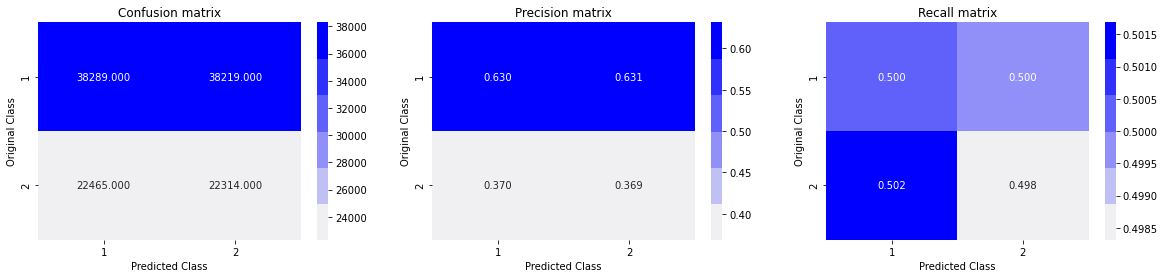

In [25]:
# We need to generate 9 numbers and the sum of numbers should be 1.
# One solution is to genarate 9 numbers and divide each of the numbers by their sum.
# We create an output array that has exactly the same size as our CV data.

predicted_y = np.zeros((test_len, 2))

for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Test Data using Random Model:", log_loss(y_test, predicted_y, eps=1e-15))
predicted_y = np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

- __Logistic Regression with Hyperparameter Tuning__

For values of alpha = 1e-05 The log_loss is: 0.5986259768033978
For values of alpha = 0.0001 The log_loss is: 0.4553395230645014
For values of alpha = 0.001 The log_loss is: 0.4379834966282478
For values of alpha = 0.01 The log_loss is: 0.43975753359617664
For values of alpha = 0.1 The log_loss is: 0.43616229373537735
For values of alpha = 1 The log_loss is: 0.46725892406643077
For values of alpha = 10 The log_loss is: 0.5135081853457476


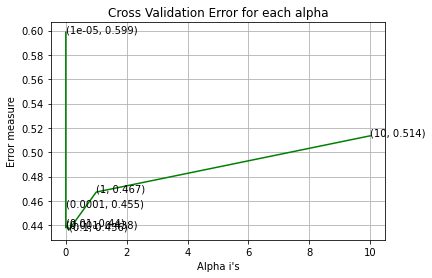

For values of best alpha = 0.1 The Train log_loss is: 0.43306229012701597
For values of best alpha = 0.1 The Test log_loss is: 0.43616229373537735
Total number of data points : 121287


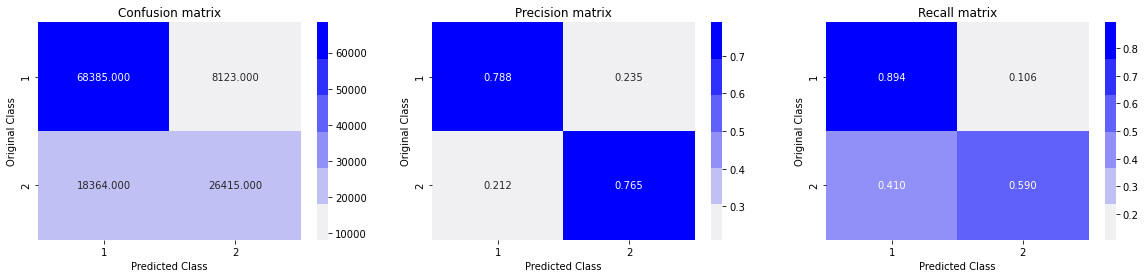

In [26]:
alpha = [10 ** x for x in range(-5, 2)]    # hyperparam for SGD classifier.

log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha =', i, "The log_loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='g')

for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha =', alpha[best_alpha], "The Train log_loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha =', alpha[best_alpha], "The Test log_loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points :", len(predicted_y))

plot_confusion_matrix(y_test, predicted_y)

- __XGBoost__

In [20]:
params = {}

params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log_loss is:", log_loss(y_test, predict_y, eps=1e-15))

[0]	train-logloss:0.68481	valid-logloss:0.68476
[10]	train-logloss:0.61536	valid-logloss:0.61538
[20]	train-logloss:0.56388	valid-logloss:0.56407
[30]	train-logloss:0.52472	valid-logloss:0.52499
[40]	train-logloss:0.49458	valid-logloss:0.49495
[50]	train-logloss:0.47139	valid-logloss:0.47181
[60]	train-logloss:0.45328	valid-logloss:0.45373
[70]	train-logloss:0.43861	valid-logloss:0.43913
[80]	train-logloss:0.42652	valid-logloss:0.42705
[90]	train-logloss:0.41661	valid-logloss:0.41721
[100]	train-logloss:0.40868	valid-logloss:0.40934
[110]	train-logloss:0.40205	valid-logloss:0.40275
[120]	train-logloss:0.39653	valid-logloss:0.39727
[130]	train-logloss:0.39202	valid-logloss:0.39277
[140]	train-logloss:0.38826	valid-logloss:0.38907
[150]	train-logloss:0.38492	valid-logloss:0.38579
[160]	train-logloss:0.38198	valid-logloss:0.38290
[170]	train-logloss:0.37921	valid-logloss:0.38021
[180]	train-logloss:0.37658	valid-logloss:0.37763
[190]	train-logloss:0.37457	valid-logloss:0.37568
[200]	train

Total number of data points : 121287


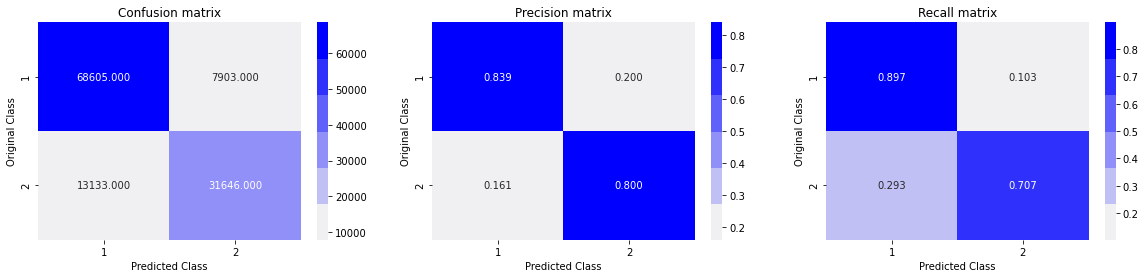

In [37]:
predicted_y = np.array(predict_y>0.5, dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

- __Random Forest__

In [17]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
predict_y = rf.predict(X_test)

print("The test accuracy is: {}%".format((round(accuracy_score(y_test, predict_y)*100, 3))))

The test accuracy is: 82.253%


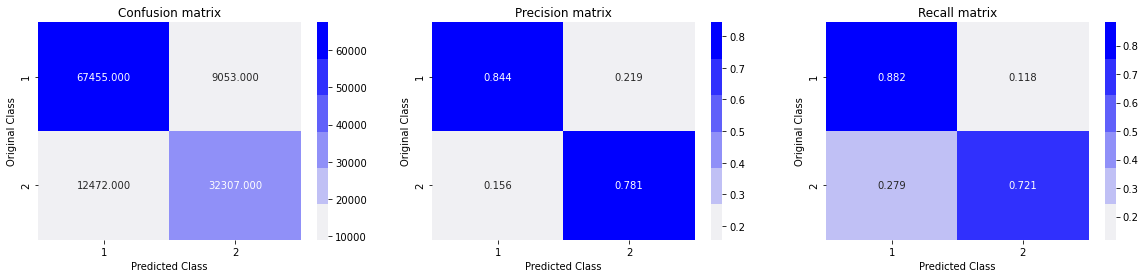

In [18]:
plot_confusion_matrix(y_test, predict_y)

In [19]:
pickle.dump(rf, open('model.pkl', 'wb'))

In [29]:
%%writefile app.py
import re
from bs4 import BeautifulSoup
import distance
from fuzzywuzzy import fuzz
import pickle
import numpy as np

Writing app.py


In [28]:
%%writefile helper.py

import re
from bs4 import BeautifulSoup
import distance
from fuzzywuzzy import fuzz
import pickle
import numpy as np
from nltk.stem.porter import PorterStemmer


def test_common_words(q1, q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    return len(w1 & w2)


def test_total_words(q1, q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    return len(w1) + len(w2)


def test_fetch_token_features(q1, q2):
    STOP_WORDS = pickle.load(open('stop.pkl', 'rb'))

    SAFE_DIV = 0.0001
    token_features = [0.0] * 8

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    # Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features


def test_fetch_length_features(q1, q2):
    length_features = [0.0] * 3

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    # Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens)) / 2

    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features


def test_fetch_fuzzy_features(q1, q2):
    fuzzy_features = [0.0] * 4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features


def test_fetch_tfidf_avgw2v_features(q):
    tfidf = pickle.load(open('tfidf.pkl', 'rb'))
    nlp = pickle.load(open('nlp.pkl', 'rb'))

    word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))
    doc1 = nlp(q)
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])

    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch idf score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0

        # compute final vec
        mean_vec1 += vec1 * idf

    mean_vec1 = mean_vec1.mean(axis=0)

    return mean_vec1


def preprocess(q):
    """
    Function to preprocess each question.
    """

    # Lower casing
    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    # q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    contractions = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    # Stemming
    porter = PorterStemmer()

    if type(q) == type(''):
        q = " ".join([porter.stem(word) for word in q.split()])

    return q


def query_point_creator(q1, q2):
    input_query = []

    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)

    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))

    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))

    input_query.append(test_common_words(q1, q2))
    input_query.append(test_total_words(q1, q2))
    input_query.append(round(test_common_words(q1, q2) / test_total_words(q1, q2), 2))

    # fetch token features
    token_features = test_fetch_token_features(q1, q2)
    input_query.extend(token_features)

    # fetch length based features
    length_features = test_fetch_length_features(q1, q2)
    input_query.extend(length_features)

    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1, q2)
    input_query.extend(fuzzy_features)

    # tf-idf W2V features for q1 & q2
    q1_tfidf_w2v = test_fetch_tfidf_avgw2v_features(q1)
    q2_tfidf_w2v = test_fetch_tfidf_avgw2v_features(q2)

    return np.hstack((np.array(input_query).reshape(1, 22), q1_tfidf_w2v.reshape(1, 300), q2_tfidf_w2v.reshape(1, 300)))

Writing helper.py


In [25]:
q1 = "What is the capital of India?"
q2 = "Where is the capital of India?"

In [26]:
rf = pickle.load(open('model.pkl', 'rb'))

In [27]:
rf.predict(query_point_creator(q1, q2))

array([0])